In [2]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


In [3]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
 9   churn_flag                    5584 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 436.4+ KB


In [5]:
df.describe()

,time_spent,first_deposit_amount,churn_flag
count,5584.000000,5584.000000,5584.000000
mean,34.509706,633.566805,0.049964
std,155.080551,2118.323263,0.217890
min,0.000000,0.000000,0.000000
25%,2.848908,50.000000,0.000000
50%,13.474708,100.000000,0.000000
75%,33.823829,500.000000,0.000000
max,8788.329450,50000.000000,1.000000


In [6]:
df.isnull().sum()

risk_tolerance                  0
investment_experience           0
liquidity_needs                 0
platform                        0
time_spent                      0
instrument_type_first_traded    0
first_deposit_amount            0
time_horizon                    0
user_id                         0
churn_flag                      0
dtype: int64

In [ ]:
'''
Steps for Detailed EDA:
Loading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.

Univariate Analysis:

For categorical features: Use bar charts to understand the frequency distribution of each category.
For numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.
Bivariate Analysis:

Compare categorical features with churn using stacked bar plots and violin plots.
Compare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.
Multivariate Analysis:

Investigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.
Check for interaction between categorical features and numerical distributions based on churn.
Correlation and Covariance:

Heatmaps to visualize correlations between numerical variables.
Calculate Variance, Standard Deviation, and other statistics for numerical features to understand the spread of the data.
Data Transformations:

If needed, perform log transformations on skewed data.
Check for multicollinearity and possible feature interactions that may affect model performance.'''

###  Univariate Analysis | Numerical Features: Distribution, spread, outliers, etc.

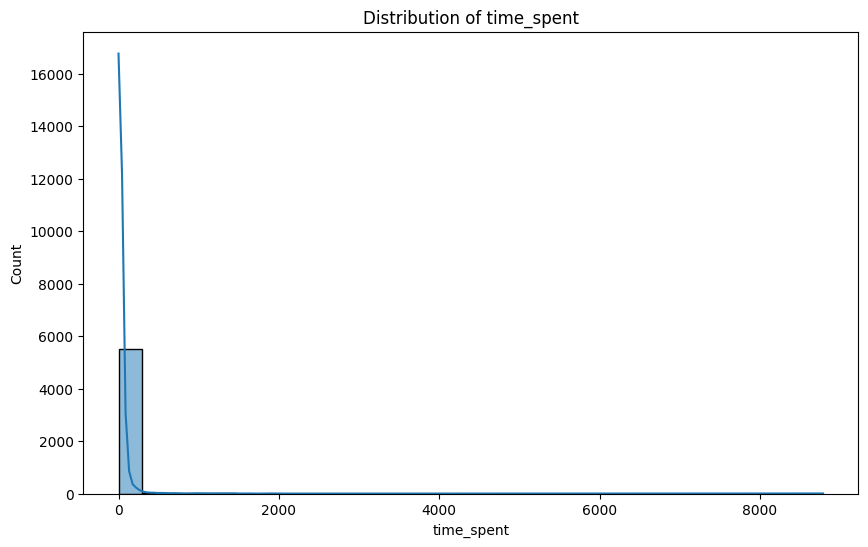

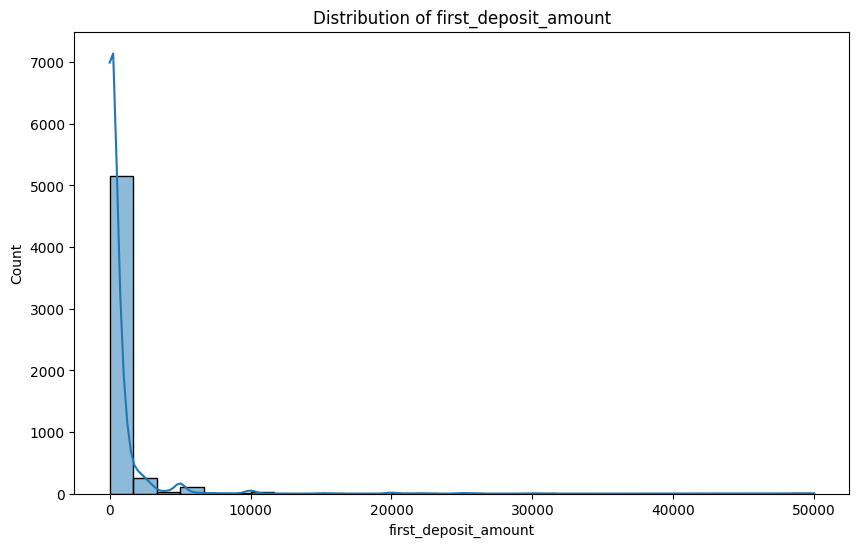

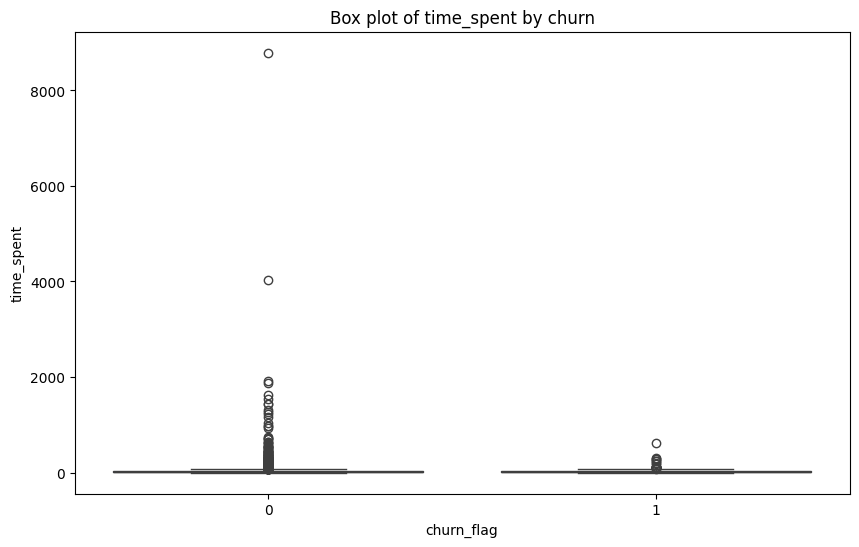

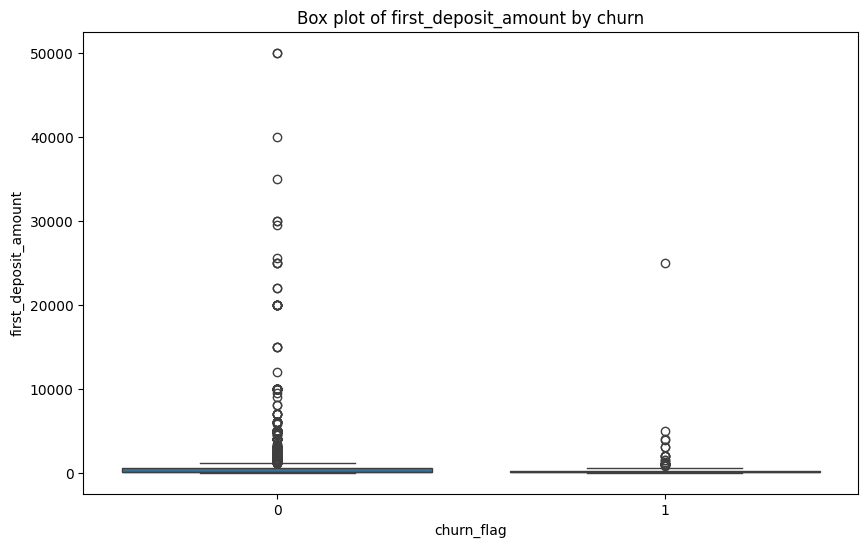

In [7]:
# Distribution plot for numerical features
num_cols = ['time_spent', 'first_deposit_amount']  # Add more numerical columns if needed
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plot for numerical features to detect outliers
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df)
    plt.title(f'Box plot of {col} by churn')
    plt.show()

### Univariate Analysis | Categorical Features: Frequency distributions

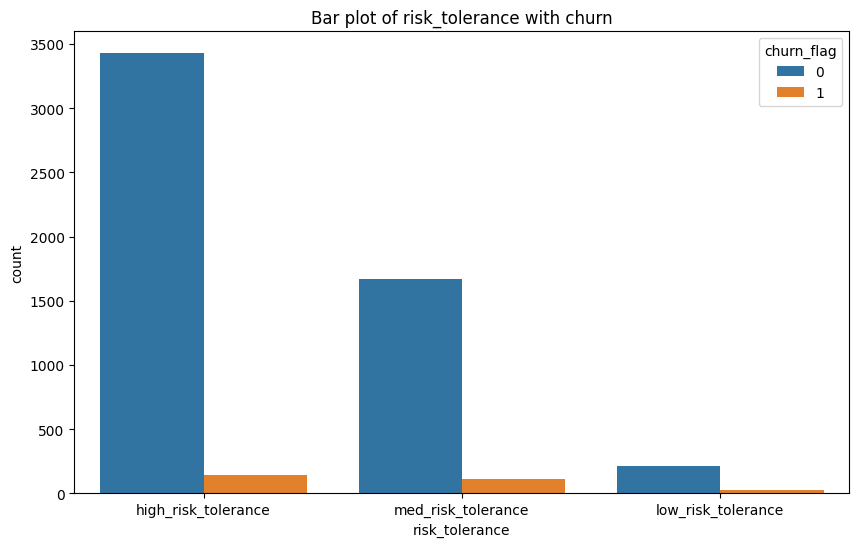

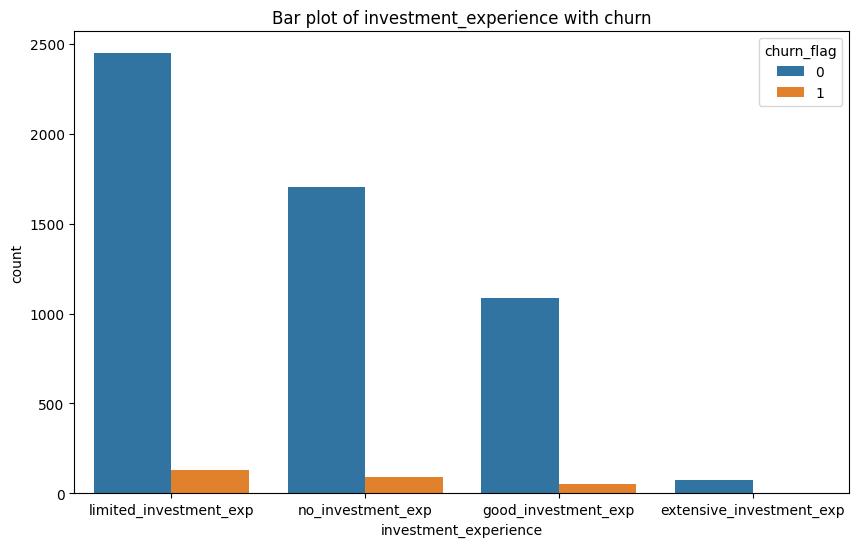

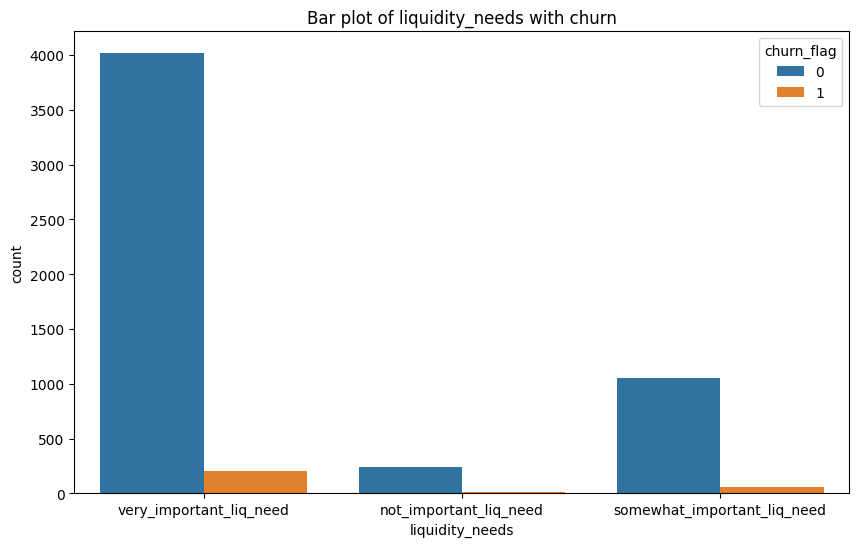

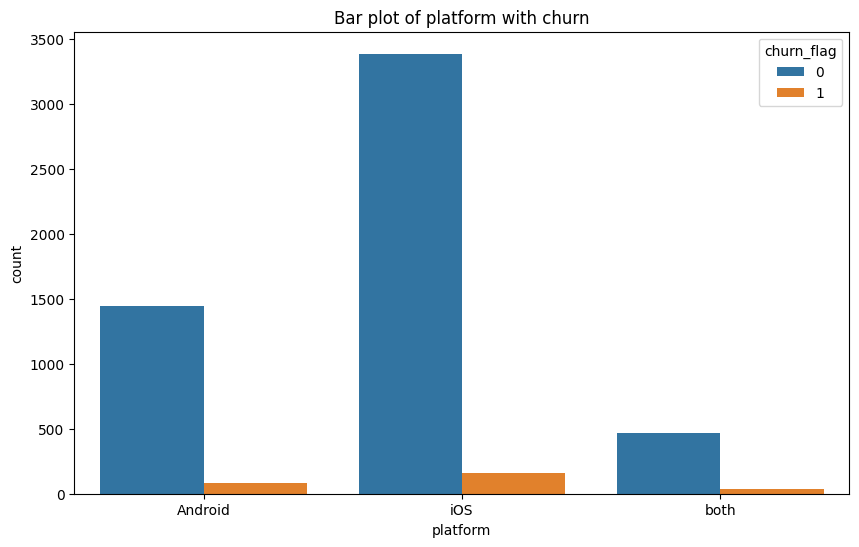

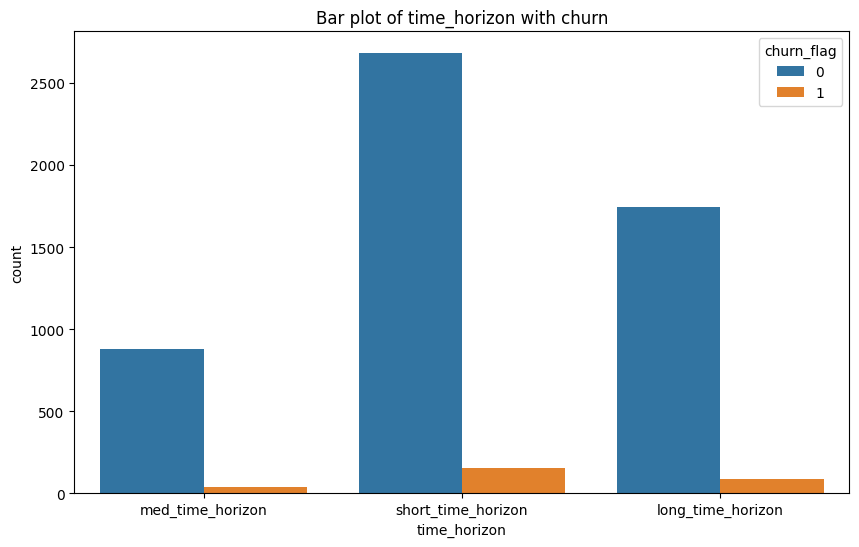

In [8]:
# Bar plot for categorical features
cat_cols = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'time_horizon']
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, hue='churn_flag')
    plt.title(f'Bar plot of {col} with churn')
    plt.show()

### Bivariate Analysis | Comparing Numerical Features with Churn

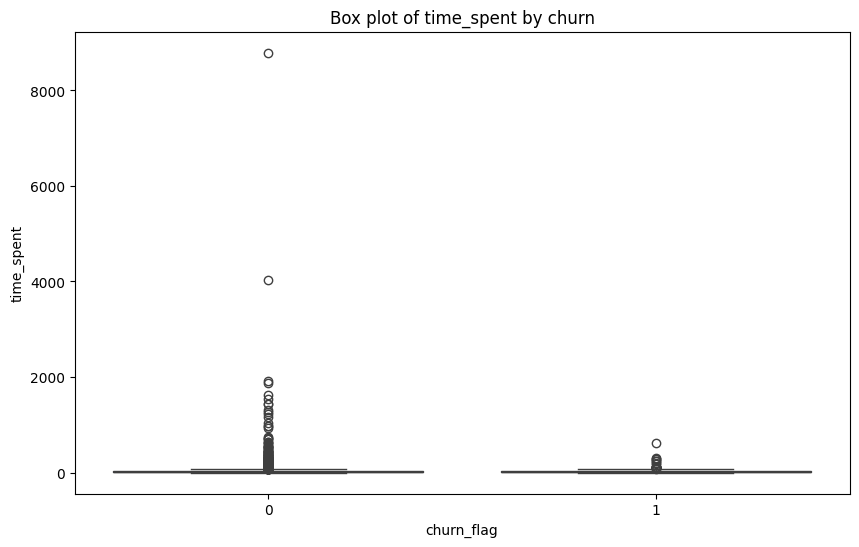

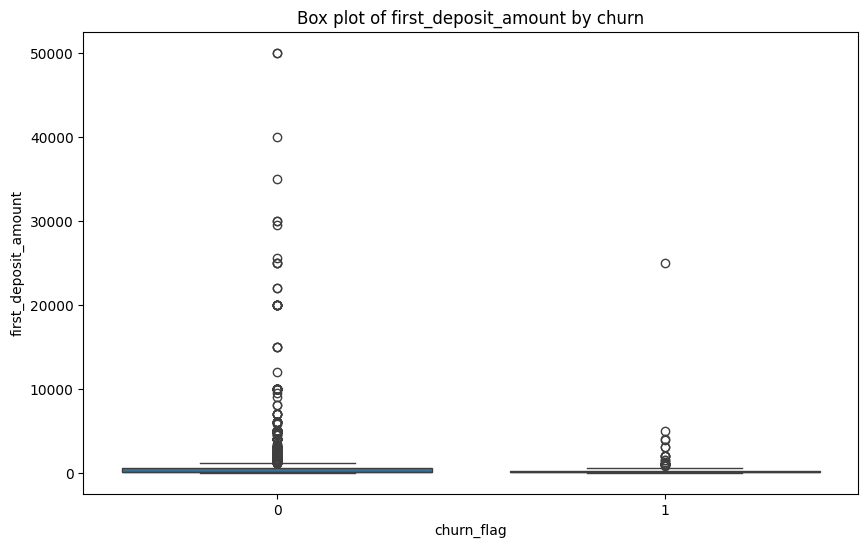

In [9]:
# Box plot for numerical columns grouped by churn
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df)
    plt.title(f'Box plot of {col} by churn')
    plt.show()

# Swarm plot for better visualization of all points
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x='churn_flag', y=col, data=df)
    plt.title(f'Swarm plot of {col} by churn')
    plt.show()

### Multivariate Analysis | Interactions and Correlations

In [ ]:
# Correlation matrix and heatmap to understand relationships between numerical variables.
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Pair plot to see pairwise relationships
sns.pairplot(df, hue='churn_flag', vars=num_cols)
plt.show()

### Understanding Distribution Patterns (Normal, Bimodal, Skewed)

In [ ]:
# KDE plot to understand the distribution shape
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[col], shade=True, hue=df['churn_flag'])
    plt.title(f'KDE plot of {col}')
    plt.show()


### Categorical Variables and Churn Relationships

In [ ]:
# Bar plots and stacked bar charts to visualize relationships between churn and categorical features.
# Stacked bar plots for churn and categorical variables
for col in cat_cols:
    pd.crosstab(df[col], df['churn_flag']).plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Stacked bar plot of {col} with churn')
    plt.show()


### Variance, Standard Deviation, and Spread of numerical variables

In [ ]:
# Variance and Standard Deviation of numerical columns
df[num_cols].var()
df[num_cols].std()

# Box plot to visualize spread (already covered in previous sections)


### Identifying Outliers using Z-Scores on numerical variables

In [ ]:
from scipy import stats

# Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[num_cols]))
outliers = (z_scores > 3).sum(axis=0)  # Count the number of outliers for each column
print(f'Number of outliers per column: {outliers}')


### Multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each numerical column
# Variance Inflation Factor (VIF) checks for multicollinearity between numerical variables:
vif_data = pd.DataFrame()
vif_data['Feature'] = num_cols
vif_data['VIF'] = [variance_inflation_factor(df[num_cols].values, i) for i in range(len(num_cols))]

print(vif_data)
